<a href="https://colab.research.google.com/github/souzamichel/ml_trading_test_code/blob/main/ml_trading_backtest_code_van_tharpe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# 0) Instalação de dependências
!pip install --quiet yfinance optuna

In [41]:
# 1) Imports
import numpy as np
import pandas as pd
import yfinance as yf
import optuna
from joblib import Parallel, delayed
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [52]:
# 2) Baixa dados históricos (AAPL 5 anos diários)
symbol = "AAPL"
df = yf.download(symbol, period="2y", interval="60m", progress=False)
if "Close" not in df.columns and "Adj Close" in df.columns:
    df.rename(columns={"Adj Close": "Close"}, inplace=True)
#df.dropna(subset=["Adj Close"], inplace=True)

/tmp/ipython-input-52-4024152777.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="2y", interval="60m", progress=False)


In [43]:

# 3) Função que simula estratégia canal + trailing stop (retorna série de lucros diários)
def simulate_channel(data, breakout, trailing):
    prices = data["Close"].to_numpy()
    n = len(prices)
    profits = np.zeros(n, dtype=float)
    pos = 0      # 0 = neutro, 1 = comprado, -1 = vendido
    entry = 0.0
    trail = 0.0

    for i in range(n):
        price = prices[i]
        if i < breakout:
            continue
        window = prices[i-breakout:i]
        high_ch, low_ch = window.max(), window.min()

        lo = max(0, i-trailing+1)
        tw = prices[lo:i+1]
        trail_high, trail_low = tw.max(), tw.min()

        ret = 0.0
        if pos == 0:
            if price > high_ch:
                pos, entry, trail = 1, price, trail_low
            elif price < low_ch:
                pos, entry, trail = -1, price, trail_high
        elif pos == 1:
            trail = max(trail, trail_low)
            if price < trail:
                ret, pos = price - entry, 0
        else:  # pos == -1
            trail = min(trail, trail_high)
            if price > trail:
                ret, pos = entry - price, 0

        profits[i] = ret

    return pd.Series(profits, index=data.index)

In [44]:
# 4) Avaliação de um fold (soma dos lucros)
def eval_fold(data, train_idx, test_idx, breakout, trailing):
    test_df = data.iloc[test_idx]
    prof = simulate_channel(test_df, breakout, trailing)
    return prof.sum()

In [45]:
# 5) Função-objetivo para Optuna
def objective(trial):
    b = trial.suggest_int("breakout", 20, 400)
    t = trial.suggest_int("trailing", 2, b)

    tss = TimeSeriesSplit(n_splits=5)
    folds = list(tss.split(df))

    scores = Parallel(n_jobs=-1)(
        delayed(eval_fold)(df, tr, te, b, t) for tr, te in folds
    )
    return float(np.mean(scores))

In [46]:
# 6) Executa otimização
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=300)

[I 2025-07-27 22:31:56,708] A new study created in memory with name: no-name-e0854b3b-f439-43a1-a820-305ace0a9782
[I 2025-07-27 22:31:56,767] Trial 0 finished with value: -0.3201934814453125 and parameters: {'breakout': 50, 'trailing': 14}. Best is trial 0 with value: -0.3201934814453125.
[I 2025-07-27 22:31:56,828] Trial 1 finished with value: -8.003695678710937 and parameters: {'breakout': 21, 'trailing': 10}. Best is trial 0 with value: -0.3201934814453125.
[I 2025-07-27 22:31:56,886] Trial 2 finished with value: -6.342437744140625 and parameters: {'breakout': 34, 'trailing': 34}. Best is trial 0 with value: -0.3201934814453125.
[I 2025-07-27 22:31:56,948] Trial 3 finished with value: -12.849502563476562 and parameters: {'breakout': 20, 'trailing': 12}. Best is trial 0 with value: -0.3201934814453125.
[I 2025-07-27 22:31:57,011] Trial 4 finished with value: -1.1140716552734375 and parameters: {'breakout': 50, 'trailing': 15}. Best is trial 0 with value: -0.3201934814453125.
[I 2025-

In [47]:
# 7) Parâmetros ótimos
best = study.best_params
print(f"Melhor breakout: {best['breakout']}, Melhor trailing: {best['trailing']}")
print(f"Retorno médio por fold: {study.best_value:.2f}")

Melhor breakout: 43, Melhor trailing: 26
Retorno médio por fold: 6.05


In [48]:
# 8) Backtest completo com os melhores parâmetros
profits = simulate_channel(df, best['breakout'], best['trailing'])
cum_profit = profits.cumsum()

/tmp/ipython-input-43-1291313397.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  profits[i] = ret


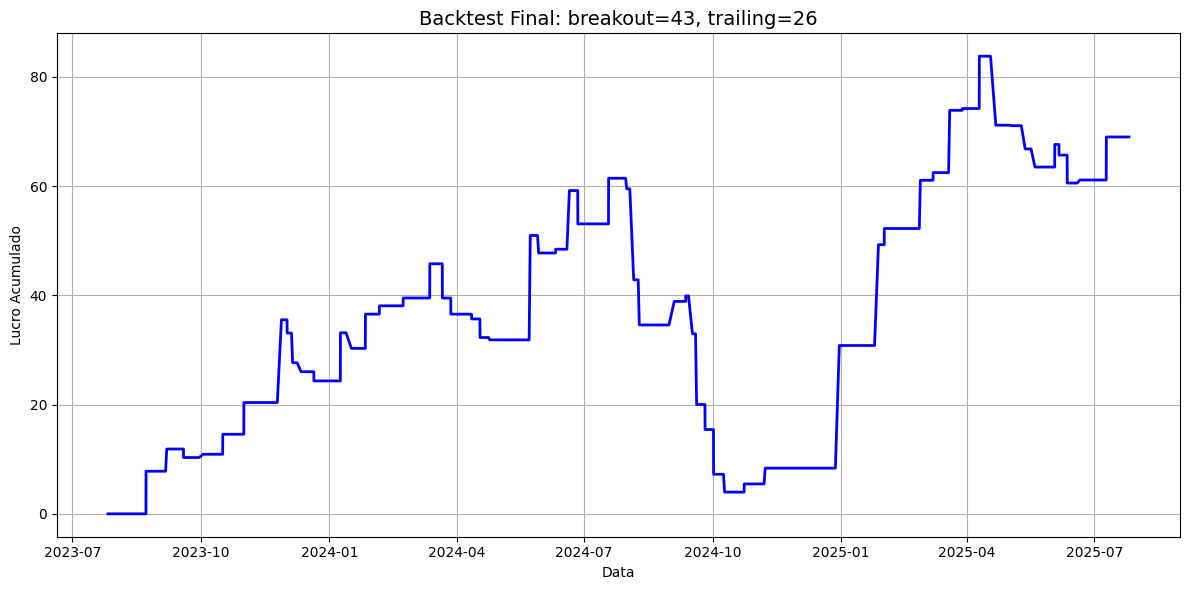

In [49]:
# 9) Plot do retorno acumulado
plt.figure(figsize=(12,6))
plt.plot(cum_profit.index, cum_profit.values, color="blue", lw=2)
plt.title(f"Backtest Final: breakout={best['breakout']}, trailing={best['trailing']}", fontsize=14)
plt.xlabel("Data")
plt.ylabel("Lucro Acumulado")
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
# 10) Lista de operações do melhor backtest
def list_trades(data, breakout, trailing):
    prices = data["Close"].to_numpy()
    dates  = data.index
    pos = 0
    entry_price = 0.0
    entry_date = None
    trail = 0.0
    trades = []

    for i in range(len(prices)):
        price = prices[i]
        if i < breakout:
            continue

        window = prices[i-breakout:i]
        high_ch, low_ch = window.max(), window.min()

        lo = max(0, i-trailing+1)
        tw = prices[lo:i+1]
        trail_high, trail_low = tw.max(), tw.min()

        if pos == 0:
            if price > high_ch:
                pos, entry_price, entry_date, trail = 1, price, dates[i], trail_low
            elif price < low_ch:
                pos, entry_price, entry_date, trail = -1, price, dates[i], trail_high

        elif pos == 1:
            trail = max(trail, trail_low)
            if price < trail:
                pnl = price - entry_price
                trades.append({
                    "Entry Date": entry_date,
                    "Entry Price": entry_price,
                    "Exit Date": dates[i],
                    "Exit Price": price,
                    "PnL": pnl
                })
                pos = 0

        else:  # pos == -1
            trail = min(trail, trail_high)
            if price > trail:
                pnl = entry_price - price
                trades.append({
                    "Entry Date": entry_date,
                    "Entry Price": entry_price,
                    "Exit Date": dates[i],
                    "Exit Price": price,
                    "PnL": pnl
                })
                pos = 0

    return pd.DataFrame(trades)

# Gera DataFrame com todas as operações
trades_df = list_trades(df, best['breakout'], best['trailing'])
print("\nOperações realizadas no melhor backtest:")
print(trades_df)

# (Opcional) Salva em CSV
trades_df.to_csv("operacoes_backtest_van_tharp.csv", index=False)
print("\nArquivo com operações salvo em 'operacoes_backtest_van_tharp.csv'")


Operações realizadas no melhor backtest:
                  Entry Date           Entry Price                 Exit Date  \
0  2023-08-04 13:30:00+00:00  [185.11000061035156] 2023-08-22 18:30:00+00:00   
1  2023-08-23 13:30:00+00:00  [180.10499572753906] 2023-09-06 13:30:00+00:00   
2  2023-09-07 13:30:00+00:00              [176.25] 2023-09-18 14:30:00+00:00   
3  2023-09-21 19:30:00+00:00  [173.92999267578125] 2023-10-02 13:30:00+00:00   
4  2023-10-05 16:30:00+00:00       [174.158203125] 2023-10-16 15:30:00+00:00   
5  2023-10-17 13:30:00+00:00   [176.4499969482422] 2023-10-31 18:30:00+00:00   
6  2023-11-01 18:30:00+00:00  [173.91000366210938] 2023-11-27 14:30:00+00:00   
7  2023-11-29 19:30:00+00:00  [189.01499938964844] 2023-12-01 16:30:00+00:00   
8  2023-12-04 14:30:00+00:00  [188.16000366210938] 2023-12-05 14:30:00+00:00   
9  2023-12-05 16:30:00+00:00  [193.75999450683594] 2023-12-11 14:30:00+00:00   
10 2023-12-13 14:30:00+00:00   [196.5200958251953] 2023-12-20 20:30:00+00:00  